In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline
g = torch.Generator().manual_seed(2147483647) # for reproducibility

torch.__version__

'2.1.1+cu121'

In [2]:
import random
with open("assets/names.txt", "r+") as f:
	words = f.read().splitlines()
	words = [word.strip() for word in words] # get rid of any trailing spaces
	words = [w for w in words if w] # get rid of any empty strings
	names = sorted(words, key=lambda x: random.random())

min_chars = min(len(v) for v in names)
max_chars = max(len(v) for v in names)
chars = sorted(list(set("".join(names))))

# in replacement of the start and end token. Every name should end with a period. and there should be no start token to begin a sequence
chars = ['.'] + chars
chars_count = len(chars)
print("names: ", names[:5])
print("number of names: ", len(names))
print("(list of chars, count): ", ("".join(chars), chars_count))
print("(max word length, min word length): ", (max_chars, min_chars))

atoi = {ch:i for i,ch in enumerate(chars)}
itoa = {i:ch for i,ch in enumerate(chars)}

# adding end token to each name
names = [list(name) + ['.'] for name in names]

names:  ['alayja', 'aviyana', 'kol', 'jamira', 'hazaiah']
number of names:  32033
(list of chars, count):  ('.abcdefghijklmnopqrstuvwxyz', 27)
(max word length, min word length):  (15, 2)


In [3]:
# hyper-params
n_embd = 10
block_size  = 3 # context length
n_embd2 = 200 # intermediate weight size
lr = 0.1 # determined based on graph
decay_rate = 0.01
batch_size = 64

In [4]:
# build_dset basically builds a rolling window on the dataset based on the context length.
def build_dset(dset, ctxt_len):
    X, Y = [], []
    for name in dset:
        context  = [0] * ctxt_len
        for ch in name:
            ix = atoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itoa[i] for i in context), '--->', itoa[ix])
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

X_train, Y_train = build_dset(names[:n1], block_size)
X_val, Y_val = build_dset(names[n1:n2], block_size)
X_test, Y_test = build_dset(names[n2:], block_size)

for c, d in zip(X_train[:5], Y_train[:5]):
    print(''.join(itoa[i.item()] for i in c), "=>", itoa[d.item()])



... => a
..a => l
.al => a
ala => y
lay => j


- similar to the mlp, but with a few differences:
- Reduction of initial loss spikes;
	- by adjusting output layer initialization
	- by adjusting tanh activation function input range (hardcoding it to 0.2 from gradient analysis)

- Batch normalization, [Paper](https://arxiv.org/pdf/1502.03167.pdf)

In [59]:
# train-test split(80, 10, 10)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

gain = 5/3 # for tanh
fan_in = block_size * n_embd # the number of input units for a weight matrix 
# parameters
C = torch.randn((27, n_embd), generator=g) 
W1 = torch.randn((block_size * n_embd, n_embd2), generator=g) * ((5/3)/(fan_in**0.5)) # hidden layer
# error using kaiming initialization -  WHY?
# - when is too small, the tanh function input is concentrated around 0,
# - when it is too large, the tanh function output is concentrated around 1

b1 = torch.randn(n_embd2, generator=g) * 0.01
W2 = torch.randn((n_embd2, 27), generator=g) * 0.01 # output layer
b2 = torch.randn(27, generator=g) * 0

#buffers
bn_gain = torch.ones((1, n_embd2))
bn_bias = torch.zeros((1, n_embd2))

params = [C, W1, b1, W2, b2, bn_gain, bn_bias]

for p in params:
    p.requires_grad = True # autograd should record operations

In [60]:
# BACKPROPAGATION

max_steps = 100000
losses = []

for i in range(max_steps):
    # minibatch construct - for efficiency
    ix = torch.randint(0, X_train.shape[0], (batch_size,))

    # forward pass
    emb = C[X_train[ix]].view(-1, block_size * n_embd)
    v = emb @ W1 + b1

    # batch norm
    mean = v.mean(dim=0, keepdim=True)
    var = v.var(dim=0, keepdim=True)
    pre_tanh = (v - mean) / (var + 1e-5).sqrt()
    pre_tanh = bn_gain * pre_tanh + bn_bias

    h = torch.tanh(pre_tanh) # intermediate layer
    logits = h @ W2 + b2
        
    loss = F.cross_entropy(logits, Y_train[ix])
    if i % 10000 == 0:
        print("(", (i * 100) / max_steps , "%) loss =", loss.item())
    
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # update
    lri = lr if max_steps > 10000 else decay_rate
    for p in params:
        p.data += - lri * p.grad 
    losses.append(loss.item())

( 0.0 %) loss = 3.313098192214966
( 10.0 %) loss = 1.9307942390441895
( 20.0 %) loss = 2.237173080444336
( 30.0 %) loss = 2.2333030700683594
( 40.0 %) loss = 2.1420576572418213
( 50.0 %) loss = 1.9617948532104492
( 60.0 %) loss = 2.131014108657837
( 70.0 %) loss = 2.067582607269287
( 80.0 %) loss = 2.16463565826416
( 90.0 %) loss = 2.1722071170806885


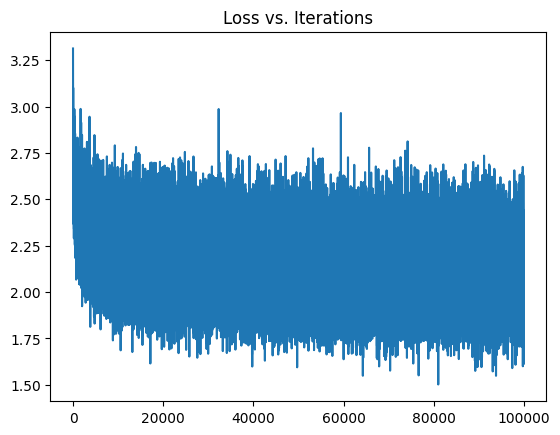

In [61]:
with torch.no_grad():
	plt.title("Loss vs. Iterations")
	plt.plot(losses)

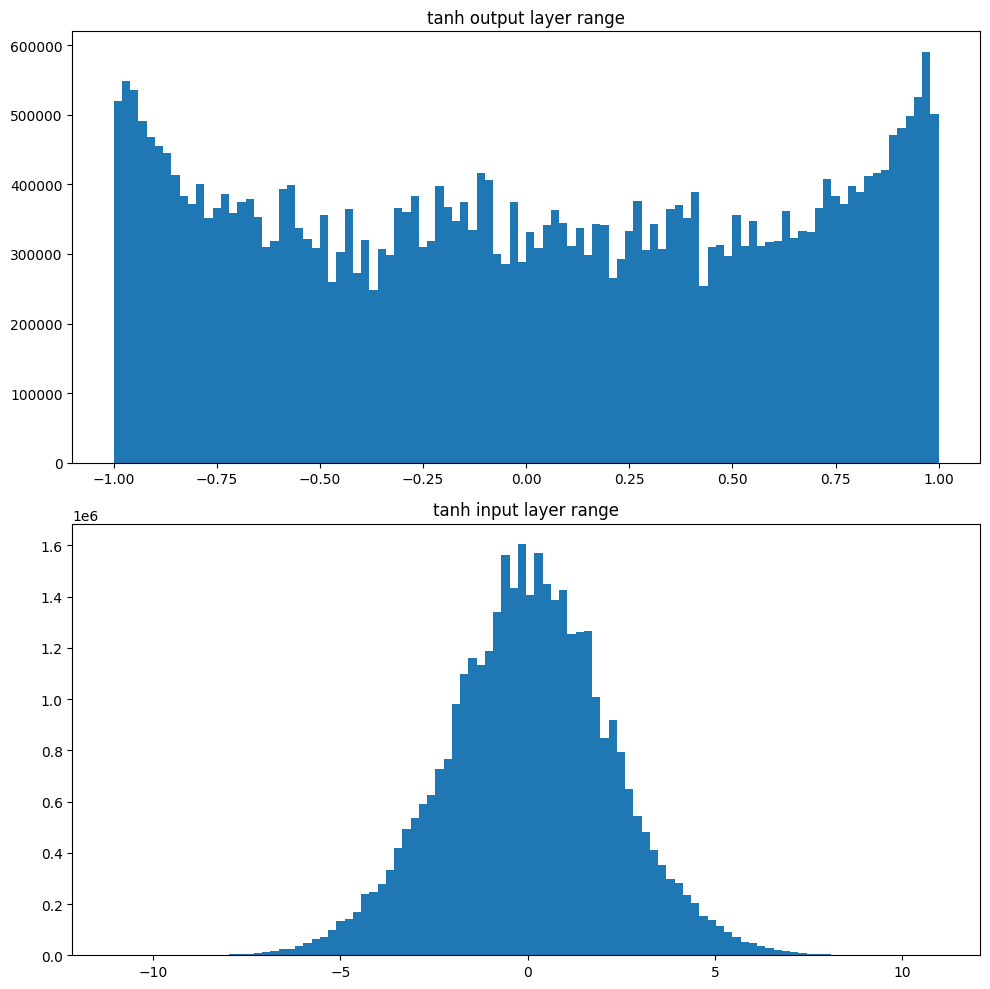

In [65]:
with torch.no_grad():
	# validation
	emb = C[X_train].view(-1, 30)
	v = emb @ W1 + b1
	pre_tanh = (v - v.mean(dim=0, keepdim=True)) / (v.var(dim=0, keepdim=True) + 1e-5).sqrt()
	h = torch.tanh(pre_tanh) # intermediate layer
	logits = h @ W2 + b2
	preds = torch.argmax(logits, dim=1)
	
	plt.figure(figsize=(10, 10))
	plt.subplot(2, 1, 1)
	plt.title("tanh output layer range")
	plt.hist(h.view(-1).numpy(), bins=100)

	plt.subplot(2, 1, 2)
	plt.title("tanh input layer range")
	plt.hist(v.view(-1).numpy(), bins=100)

	plt.tight_layout()
	plt.show()
	
	

In [66]:
@torch.no_grad()
def loss(x, y):
    emb = C[x].view(-1, 30)
    v = emb @ W1 + b1
    h = torch.tanh(v) # intermediate layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss

print("training loss: ", loss(X_train, Y_train))
print("val loss: ", loss(X_val, Y_val))
print("test loss: ", loss(X_test, Y_test))


training loss:  tensor(2.8772)
val loss:  tensor(2.9083)
test loss:  tensor(2.9201)


### Stats
|iter|init| train | test | method |
|--------|----|-----------| -------|---------|
| 1 | 13.543 | 2.834 | 2.4027 | --- |
| 2| 3.2868 |2.2233 | 2.2516| tuning output weights and bias - softmax | 
| 3| 3.3105 | 2.0768 | 2.1459 | tuning log params - tanh layer saturation | 
|4 | 3.3110 |2.0917 | 2.1517| using kaiming init |
|5 | 3.3131 | 2.8772 | 2.9083 | add batch norm layer(calculating after training) |

In [70]:
# not sure if this is the right way to do it
@torch.no_grad()
def nnl(name):
    "to calculate the likelihood of a word in a mlp model"
    x, y = build_dset([name], block_size)
    emb = C[x]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss

In [76]:
import time

with torch.no_grad():
    generated_names = []
    print("generating...")
    start_time = time.time()
    while True:
        out = []
        probs = None
        context  = [0] * block_size
        while True:
            emb = C[torch.tensor(context)].view(-1, block_size * n_embd)
            h = torch.tanh(emb @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            # print(probs)
            ix = torch.multinomial(probs, num_samples=1, generator=g)
            context = context[1:] + [ix]
            out.append(ix)
            
            if ix == 0:
                break

        word = ''.join(itoa[i.item()] for i in out)
        if nnl(word) < 1.5 and len(word) > 3 and word not in generated_names:
            print("+ valid word: ", word)
            generated_names.append(word) 
        if len(generated_names) == 10:
            break
    duration = time.time() - start_time
    print("duration: ", duration)

generating...
+ valid word:  dalah.
+ valid word:  xavel.
+ valid word:  lah.
+ valid word:  khylah.
+ valid word:  calah.
+ valid word:  fitzalda.
+ valid word:  zalda.
+ valid word:  shalan.
+ valid word:  azlington.
+ valid word:  zakhukwu.
duration:  0.3243715763092041
